In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing
from sklearn.preprocessing import LabelEncoder
import dalex as dx
from dalex.fairness import resample
from dalex.fairness import roc_pivot
import tensorflow.compat.v1 as tf

# Disable eager execution for Adversarial Debiasing
tf.disable_eager_execution()

# Display output in notebook
%matplotlib inline

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [2]:
# Load and Explore Dataset
# Load the dataset
file_path = 'project-data.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Display dataset info
print("Dataset Shape:", data.shape)
print("Dataset Columns:", data.columns)
print(data.head())
print(data.isnull().sum())

Dataset Shape: (614, 13)
Dataset Columns: Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2

In [3]:
data_info = {
    "Shape": data.shape,
    "Columns": data.columns.tolist(),
    "Data Types": data.dtypes.to_dict(),
    "Missing Values": data.isnull().sum().to_dict(),
    "First Few Rows": data.head().to_dict()
}

data_info

{'Shape': (614, 13),
 'Columns': ['Loan_ID',
  'Gender',
  'Married',
  'Dependents',
  'Education',
  'Self_Employed',
  'ApplicantIncome',
  'CoapplicantIncome',
  'LoanAmount',
  'Loan_Amount_Term',
  'Credit_History',
  'Property_Area',
  'Loan_Status'],
 'Data Types': {'Loan_ID': dtype('O'),
  'Gender': dtype('O'),
  'Married': dtype('O'),
  'Dependents': dtype('O'),
  'Education': dtype('O'),
  'Self_Employed': dtype('O'),
  'ApplicantIncome': dtype('int64'),
  'CoapplicantIncome': dtype('float64'),
  'LoanAmount': dtype('float64'),
  'Loan_Amount_Term': dtype('float64'),
  'Credit_History': dtype('float64'),
  'Property_Area': dtype('O'),
  'Loan_Status': dtype('O')},
 'Missing Values': {'Loan_ID': 0,
  'Gender': 13,
  'Married': 3,
  'Dependents': 15,
  'Education': 0,
  'Self_Employed': 32,
  'ApplicantIncome': 0,
  'CoapplicantIncome': 0,
  'LoanAmount': 22,
  'Loan_Amount_Term': 14,
  'Credit_History': 50,
  'Property_Area': 0,
  'Loan_Status': 0},
 'First Few Rows': {'Loan_

In [4]:
# 1. Clean the data
def clean_data(data):
    """Handle missing values and standardize categorical data."""
    # Fill missing values
    data['Gender'].fillna(data['Gender'].mode()[0], inplace=True)
    data['Married'].fillna(data['Married'].mode()[0], inplace=True)
    data['Dependents'].fillna(data['Dependents'].mode()[0], inplace=True)
    data['Self_Employed'].fillna(data['Self_Employed'].mode()[0], inplace=True)
    data['LoanAmount'].fillna(data['LoanAmount'].median(), inplace=True)
    data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mode()[0], inplace=True)
    data['Credit_History'].fillna(data['Credit_History'].mode()[0], inplace=True)

    # Standardize 'Dependents' column
    data['Dependents'] = data['Dependents'].replace({'3+': '3+'})
    return data

# Clean the data
cleaned_data = clean_data(data)
# Display cleaned data info
print("Missing Values After Cleaning:\n", cleaned_data.isnull().sum())

# 2. Preprocess the data
def preprocess_data(data):
    """Encode categorical features and normalize numerical features."""
    # Encode categorical variables
    label_encoders = {}
    categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
    for col in categorical_cols:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le

    # Normalize numerical features
    scaler = MinMaxScaler()
    numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

    return data, label_encoders

# Preprocess the data
preprocessed_data, label_encoders = preprocess_data(cleaned_data)

# Sensitive attributes for fairness analysis
sensitive_attributes = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Dependents']

# Summary of data preparation
print("Data preparation completed.")
print(f"Sensitive attributes: {sensitive_attributes}")

Missing Values After Cleaning:
 Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64
Data preparation completed.
Sensitive attributes: ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Dependents']


/var/folders/v7/_1xlyqvs26z81fbvft3w9tlr0000gn/T/ipykernel_93365/2384213584.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Gender'].fillna(data['Gender'].mode()[0], inplace=True)
/var/folders/v7/_1xlyqvs26z81fbvft3w9tlr0000gn/T/ipykernel_93365/2384213584.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

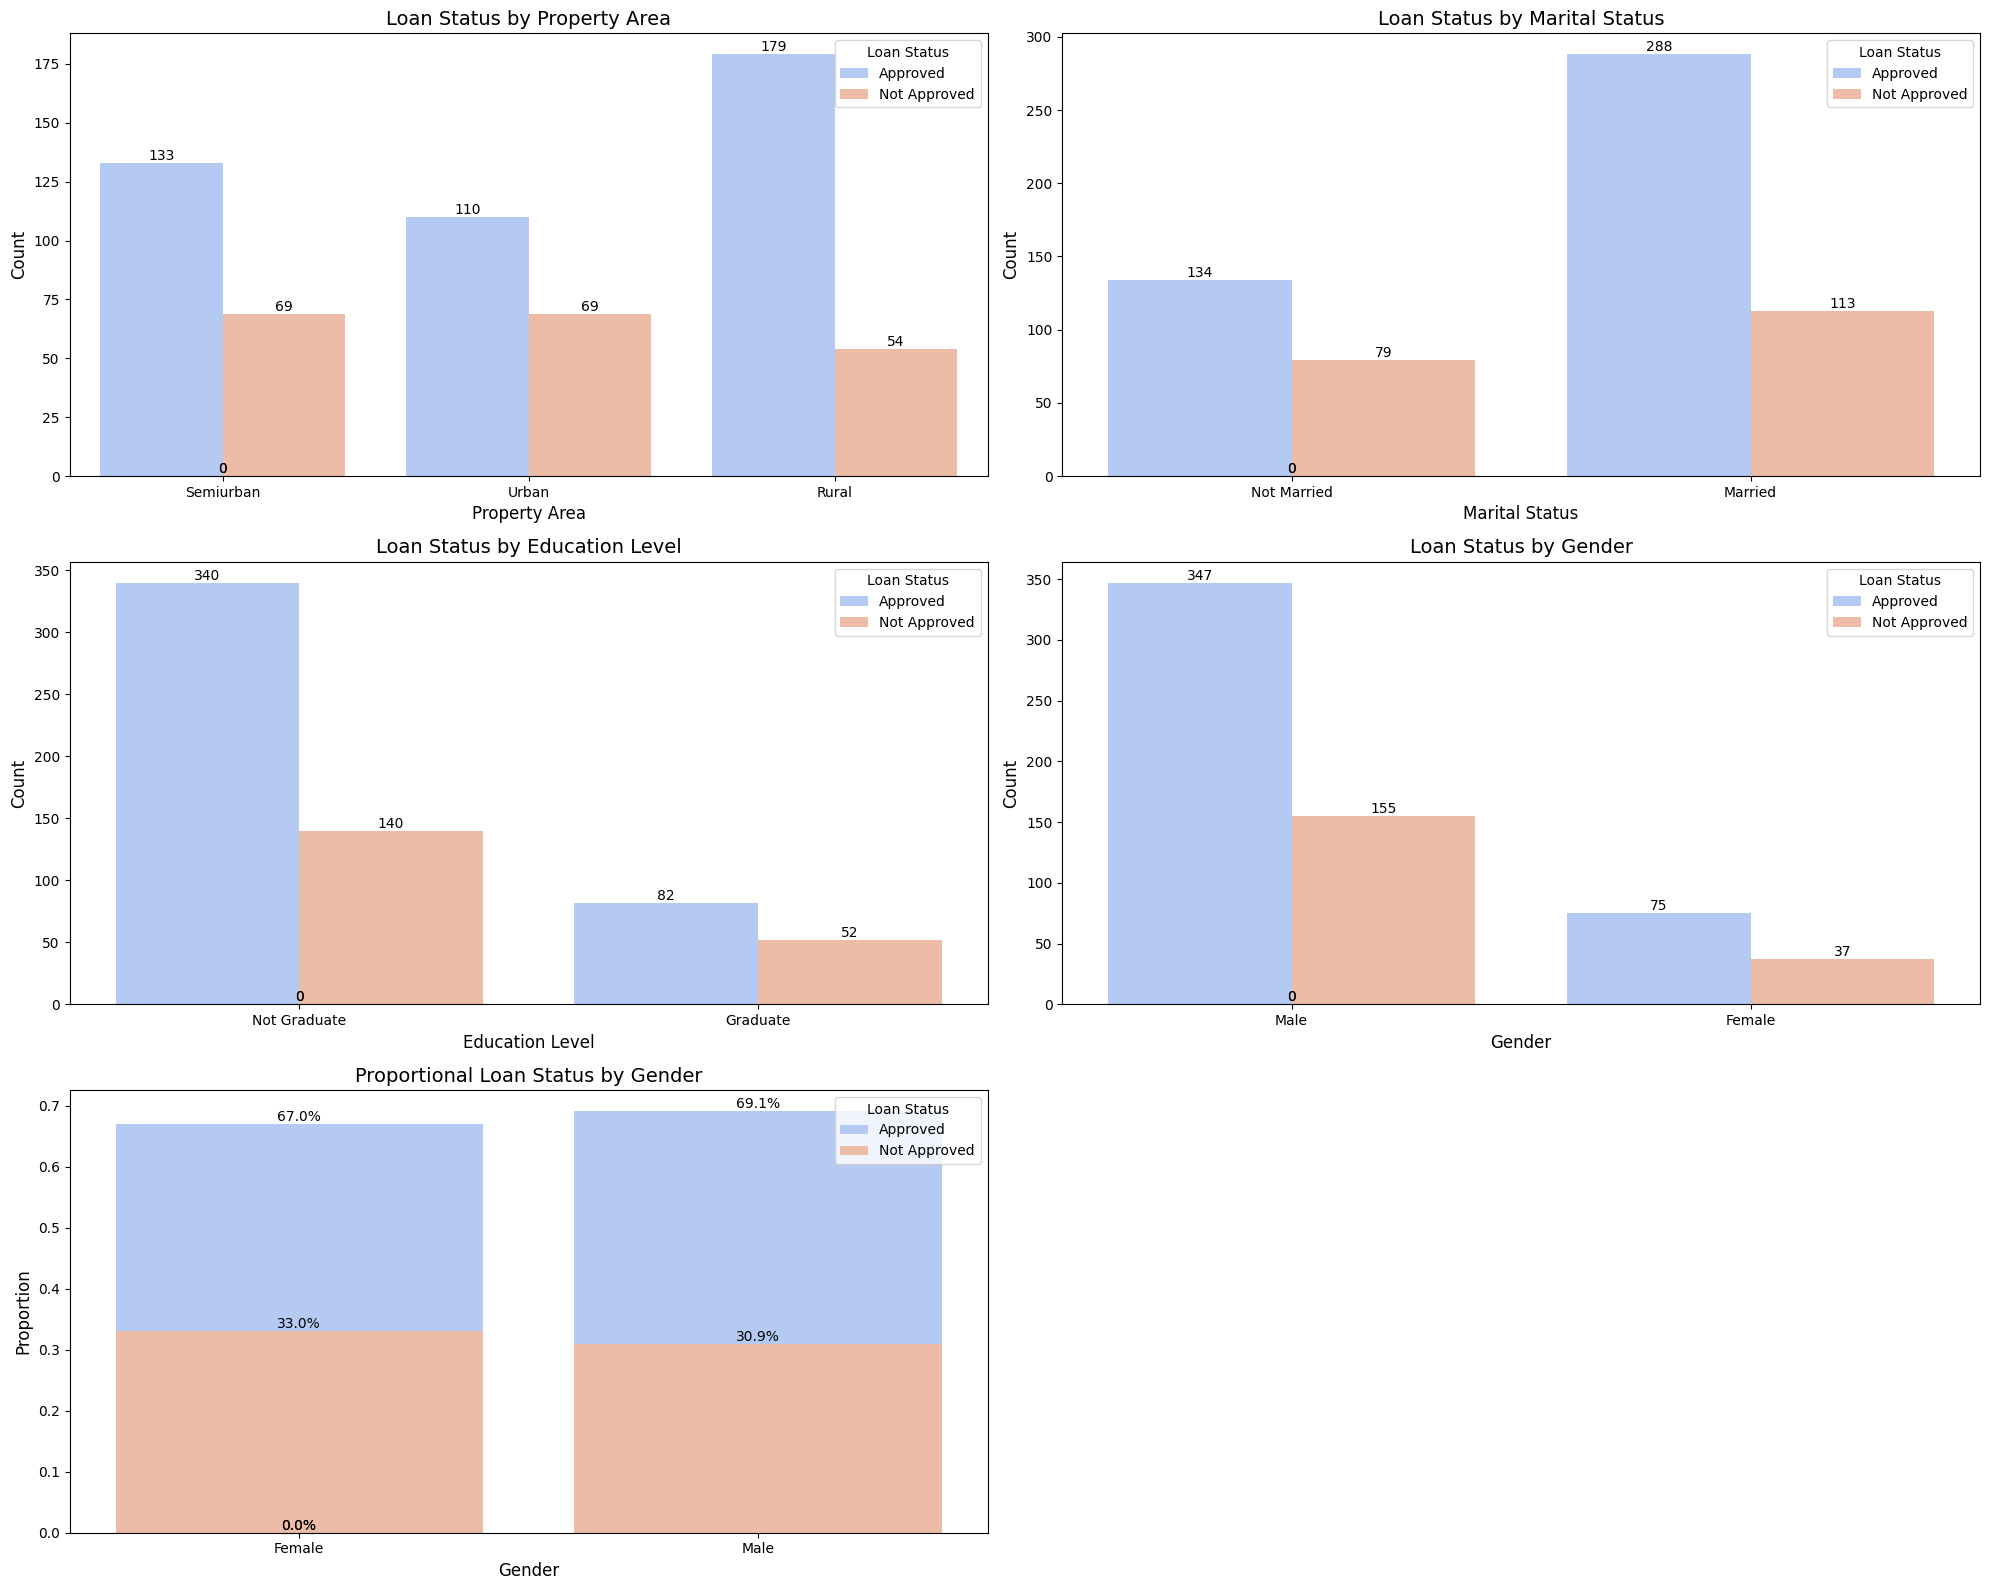

/var/folders/v7/_1xlyqvs26z81fbvft3w9tlr0000gn/T/ipykernel_93365/1380275414.py:122: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/v7/_1xlyqvs26z81fbvft3w9tlr0000gn/T/ipykernel_93365/1380275414.py:129: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/v7/_1xlyqvs26z81fbvft3w9tlr0000gn/T/ipykernel_93365/1380275414.py:136: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




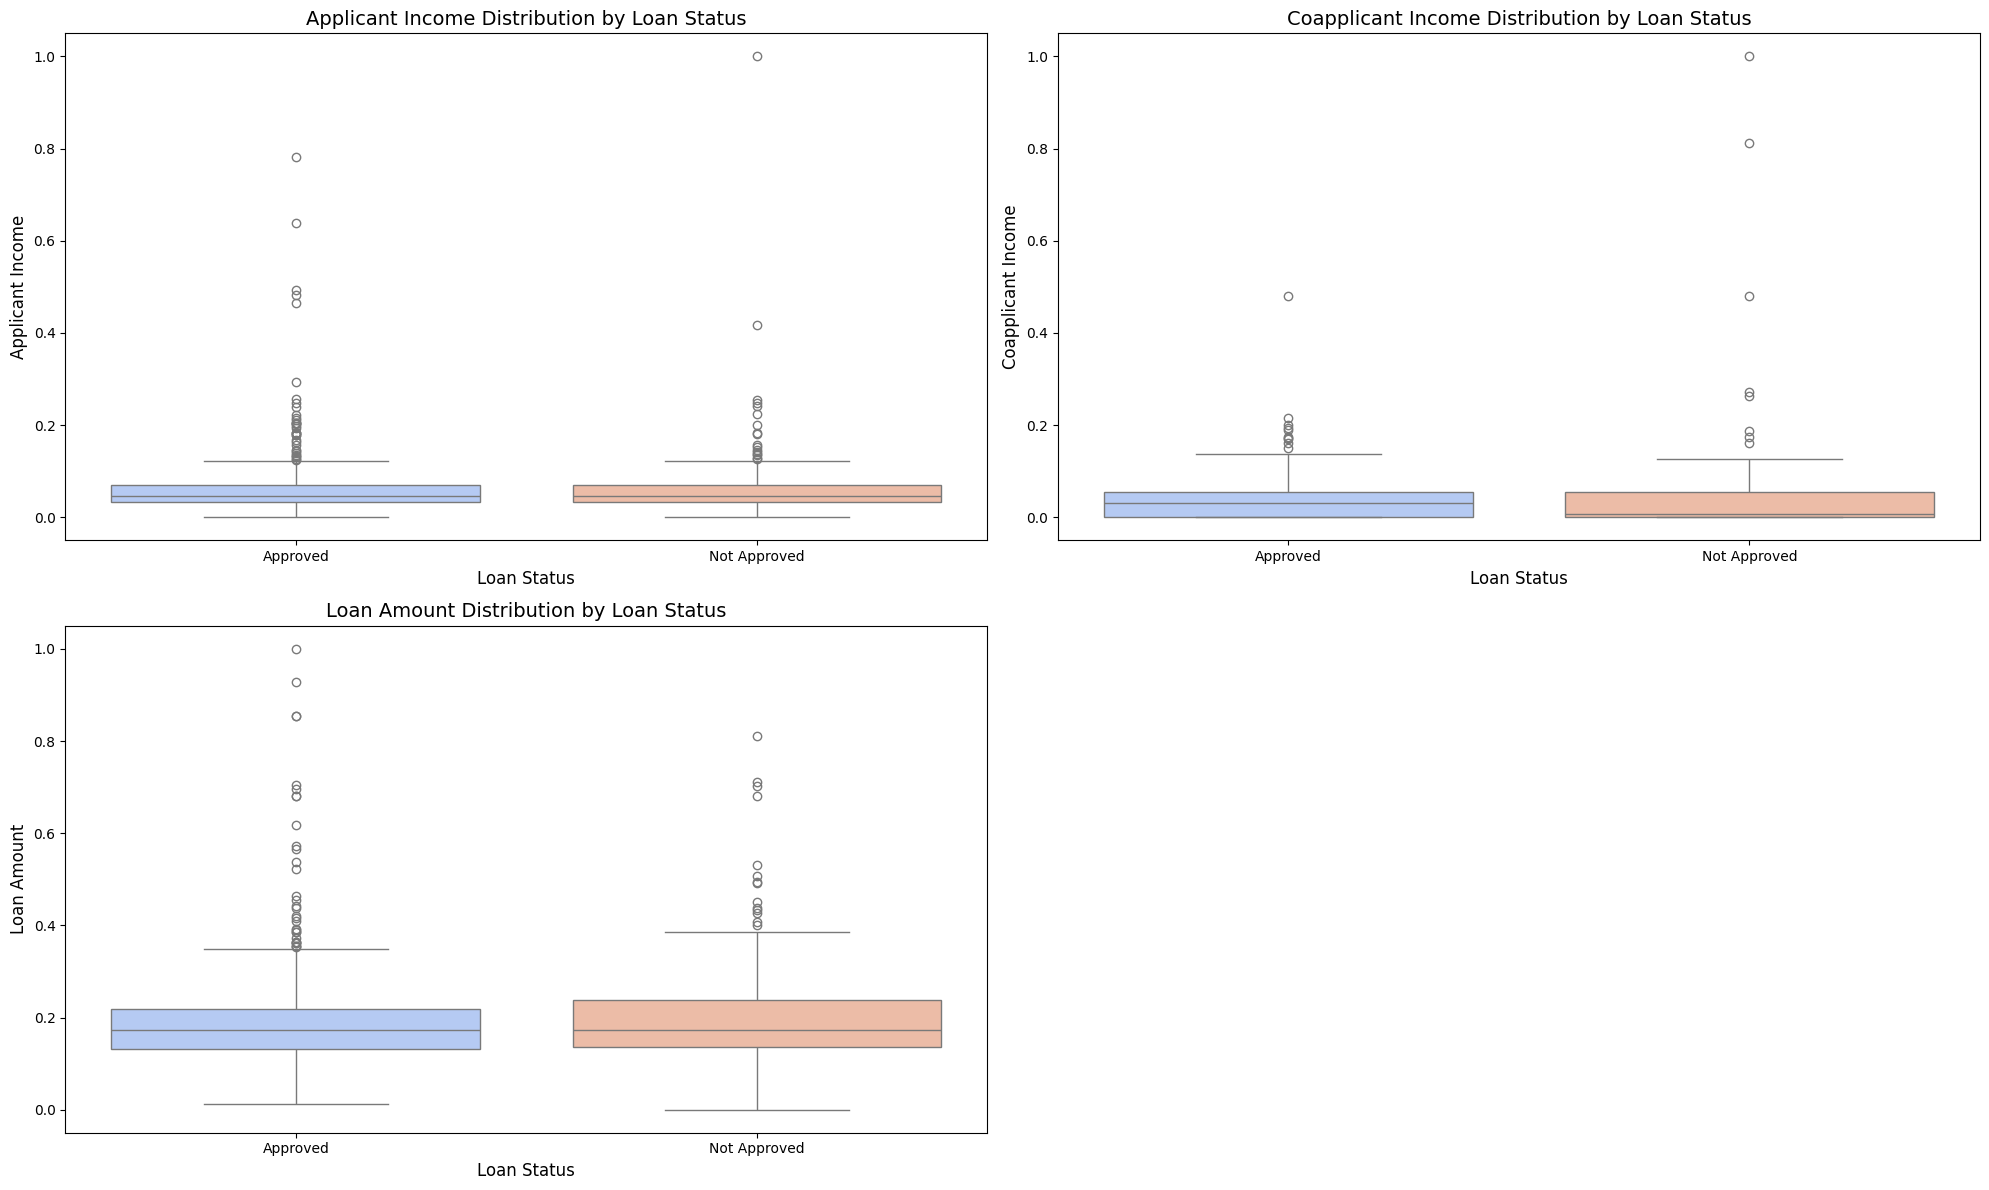

In [13]:
# Data Visualization

# Replace encoded values dynamically for better visualization
def replace_encoded_values(data):
    """Replace encoded values dynamically for all relevant columns."""
    # Define a mapping of columns to their replacements
    replacement_map = {
        'Loan_Status': {1: 'Approved', 0: 'Not Approved'},
        'Gender': {1: 'Male', 0: 'Female'},
        'Married': {1: 'Married', 0: 'Not Married'},
        'Education': {1: 'Graduate', 0: 'Not Graduate'},
        'Credit_History': {1: 'Has History', 0: 'No History'},
        'Self_Employed': {1: 'Self-Employed', 0: 'Not Self-Employed'},
        'Property_Area': {0: 'Urban', 1: 'Rural', 2: 'Semiurban'}  # Example mapping
    }

    # Apply replacements dynamically
    for col, mapping in replacement_map.items():
        if col in data.columns:
            data[col] = data[col].replace(mapping)
    return data

def visualize_biases(data):
    """Generate visualizations with consistent labels, preserved colors, and corrected proportional chart."""
    # Replace encoded values dynamically
    data = replace_encoded_values(data)

    plt.figure(figsize=(20, 16))


    # Loan Status by Marital Status
    plt.subplot(3, 2, 2)
    plot = sns.countplot(data=data, x='Married', hue='Loan_Status', palette='coolwarm')
    plt.title('Loan Status by Marital Status', fontsize=14)
    plt.xlabel('Marital Status', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title='Loan Status', fontsize=10)
    for p in plot.patches:
        plot.annotate(f'{int(p.get_height())}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', fontsize=10, color='black',
                      xytext=(0, 5), textcoords='offset points')

    # Loan Status by Education Level
    plt.subplot(3, 2, 3)
    plot = sns.countplot(data=data, x='Education', hue='Loan_Status', palette='coolwarm')
    plt.title('Loan Status by Education Level', fontsize=14)
    plt.xlabel('Education Level', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title='Loan Status', fontsize=10)
    for p in plot.patches:
        plot.annotate(f'{int(p.get_height())}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', fontsize=10, color='black',
                      xytext=(0, 5), textcoords='offset points')

    # Loan Status by Property Area
    plt.subplot(3, 2, 1)
    plot = sns.countplot(data=data, x='Property_Area', hue='Loan_Status', palette='coolwarm')
    plt.title('Loan Status by Property Area', fontsize=14)
    plt.xlabel('Property Area', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title='Loan Status', fontsize=10)
    for p in plot.patches:
        plot.annotate(f'{int(p.get_height())}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', fontsize=10, color='black',
                      xytext=(0, 5), textcoords='offset points')


    # Loan Status by Gender
    plt.subplot(3, 2, 4)
    plot = sns.countplot(data=data, x='Gender', hue='Loan_Status', palette='coolwarm')
    plt.title('Loan Status by Gender', fontsize=14)
    plt.xlabel('Gender', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title='Loan Status', fontsize=10)
    for p in plot.patches:
        plot.annotate(f'{int(p.get_height())}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', fontsize=10, color='black',
                      xytext=(0, 5), textcoords='offset points')

    # Corrected Proportional Loan Status by Gender
    plt.subplot(3, 2, 5)
    gender_counts = data.groupby(['Gender', 'Loan_Status']).size().reset_index(name='counts')
    total_counts = gender_counts.groupby('Gender')['counts'].transform('sum')
    gender_counts['proportion'] = gender_counts['counts'] / total_counts

    # Create the proportional bar chart
    plot = sns.barplot(
        data=gender_counts,
        x='Gender',
        y='proportion',
        hue='Loan_Status',
        palette='coolwarm',
        dodge=False
    )
    plt.title('Proportional Loan Status by Gender', fontsize=14)
    plt.xlabel('Gender', fontsize=12)
    plt.ylabel('Proportion', fontsize=12)
    plt.legend(title='Loan Status', fontsize=10)

    # Annotate proportions on the bars
    for p in plot.patches:
        proportion = f"{p.get_height() * 100:.1f}%"
        plot.annotate(
            proportion,
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', fontsize=10, color='black',
            xytext=(0, 5), textcoords='offset points'
        )

    plt.tight_layout()
    plt.show()

    # Numerical Feature Analysis
    plt.figure(figsize=(20, 12))

    # Applicant Income by Loan Status
    plt.subplot(2, 2, 1)
    sns.boxplot(data=data, x='Loan_Status', y='ApplicantIncome', palette='coolwarm')
    plt.title('Applicant Income Distribution by Loan Status', fontsize=14)
    plt.xlabel('Loan Status', fontsize=12)
    plt.ylabel('Applicant Income', fontsize=12)

    # Coapplicant Income by Loan Status
    plt.subplot(2, 2, 2)
    sns.boxplot(data=data, x='Loan_Status', y='CoapplicantIncome', palette='coolwarm')
    plt.title('Coapplicant Income Distribution by Loan Status', fontsize=14)
    plt.xlabel('Loan Status', fontsize=12)
    plt.ylabel('Coapplicant Income', fontsize=12)

    # Loan Amount by Loan Status
    plt.subplot(2, 2, 3)
    sns.boxplot(data=data, x='Loan_Status', y='LoanAmount', palette='coolwarm')
    plt.title('Loan Amount Distribution by Loan Status', fontsize=14)
    plt.xlabel('Loan Status', fontsize=12)
    plt.ylabel('Loan Amount', fontsize=12)

    plt.tight_layout()
    plt.show()

# Visualize biases
visualize_biases(data)

In [6]:
# Correct Feature Encoding and Normalization
def encode_features(data):
    """Encode all categorical features using LabelEncoder."""
    label_encoders = {}
    categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 
                           'Property_Area', 'Loan_Status', 'Credit_History']
    for col in categorical_columns:
        if col in data.columns:
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col].astype(str))  # Ensure strings are encoded
            label_encoders[col] = le
    return data, label_encoders

# Normalize numerical columns
def normalize_features(data):
    """Scale numerical columns to the range [0, 1]."""
    scaler = MinMaxScaler()
    numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
    data[numerical_columns] = scaler.fit_transform(data[numerical_columns])
    return data

# Reapply encoding and normalization
encoded_data, label_encoders = encode_features(cleaned_data.copy())
normalized_data = normalize_features(encoded_data)

# Split the dataset
X = normalized_data.drop(columns=['Loan_ID', 'Loan_Status'])
y = normalized_data['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [7]:
# Train the Baseline Model
baseline_model = LogisticRegression(random_state=42)
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)

# Evaluate the Baseline Model
print("Baseline Accuracy:", accuracy_score(y_test, y_pred))
print("Baseline Classification Report:\n", classification_report(y_test, y_pred))

Baseline Accuracy: 0.7837837837837838
Baseline Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.98      0.86       120
           1       0.93      0.42      0.57        65

    accuracy                           0.78       185
   macro avg       0.84      0.70      0.71       185
weighted avg       0.82      0.78      0.76       185



/Users/harold.g/Library/Caches/pypoetry/virtualenvs/loan-approval-system-with-bias-mitigation-uCPzHwT8-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## **Baseline Model Performance**

The baseline Logistic Regression model was trained without fairness considerations. Below are the results:

- **Accuracy**: 78.4%
- **Classification Report**:
  - **Precision**: Higher for class `1` (Approved).
  - **Recall**: Lower for class `1`, indicating bias in identifying positive outcomes.
  - **F1-Score**: Lower for class `1`.

### **Key Observations**:
1. The model struggles to predict positive outcomes (`Loan_Status = 1`), as shown by the low recall for this class.
2. The weighted average F1-score reflects an imbalance in prediction quality across classes.

#### **Fairness Metrics**:
- **Statistical Parity Difference**: 0.13
  - Positive but indicates some disparity in approval rates between sensitive groups (e.g., Gender).

The chart below summarizes the fairness metrics.

In [8]:
# Evaluate fairness in comparison to the privileged group
exp_decisiontree_base = dx.Explainer(baseline_model, X_test,
                                     y_test, verbose=True)

fairness_decisiontree_base = exp_decisiontree_base.model_fairness(protected=X_test["Gender"],
                                                                  privileged=1,
                                                                  label="DecisionTree_base")
fairness_decisiontree_base.fairness_check()
fairness_decisiontree_base.plot()

/Users/harold.g/Library/Caches/pypoetry/virtualenvs/loan-approval-system-with-bias-mitigation-uCPzHwT8-py3.11/lib/python3.11/site-packages/dalex/fairness/_group_fairness/utils.py:209: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data = data.stack(dropna=False)


Preparation of a new explainer is initiated

  -> data              : 185 rows 11 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 185 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x150266b60> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0729, mean = 0.301, max = 0.944
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.791, mean = 0.0508, max = 0.924
  -> model_info        : package sklearn

A new explainer has been created!
No bias was detected!

Conclusion: your model is fair in terms of checked fairness criteria.

Ratios of metrics, bas

## **Impact of Bias Mitigation**

Three bias mitigation techniques were applied, and their impact on fairness metrics is as follows:

### 1. **Pre-processing: Reweighing**
- Statistical Parity Difference: `-1.11e-16` (Effectively zero)
- This technique equalizes approval rates across groups but does not directly optimize accuracy.

### 2. **In-processing: Adversarial Debiasing**
- Statistical Parity Difference: `0.0`
- This technique eliminates disparity in approval rates while balancing accuracy.

### 3. **Post-processing: Calibrated Equal Odds**
- Statistical Parity Difference: `0.46`
- Achieves partial fairness improvement but remains less effective compared to the previous methods.

The following chart visualizes the fairness metrics across these methods.

In [9]:
# Convert to AIF360 dataset
protected_attribute = 'Gender'
X_train['Loan_Status'] = y_train
X_test['Loan_Status'] = y_test
train_dataset = BinaryLabelDataset(df=X_train,
                                   label_names=['Loan_Status'],
                                   protected_attribute_names=[protected_attribute])
test_dataset = BinaryLabelDataset(df=X_test,
                                  label_names=['Loan_Status'],
                                  protected_attribute_names=[protected_attribute])

# Evaluate fairness of the baseline model
metric = BinaryLabelDatasetMetric(test_dataset, privileged_groups=[{protected_attribute: 1}], unprivileged_groups=[{protected_attribute: 0}])
print("Baseline Statistical Parity Difference:", metric.statistical_parity_difference())


Baseline Statistical Parity Difference: 0.13307552320291177


In [10]:
# Bias Mitigation Techniques

# Pre-processing: Reweighing
rw = Reweighing(privileged_groups=[{protected_attribute: 1}], unprivileged_groups=[{protected_attribute: 0}])
rw_train_dataset = rw.fit_transform(train_dataset)

# In-processing: Adversarial Debiasing
sess = tf.Session()
adv_debias = AdversarialDebiasing(privileged_groups=[{protected_attribute: 1}],
                                  unprivileged_groups=[{protected_attribute: 0}],
                                  scope_name='debias',
                                  sess=sess)
adv_debias.fit(rw_train_dataset)
debias_test_dataset = adv_debias.predict(test_dataset)

# Post-processing: Calibrated Equal Odds
ceop = CalibratedEqOddsPostprocessing(privileged_groups=[{protected_attribute: 1}],
                                      unprivileged_groups=[{protected_attribute: 0}])
ceop.fit(test_dataset, debias_test_dataset)
postprocess_test_dataset = ceop.predict(test_dataset)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
I0000 00:00:1733324865.949078 5057905 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


epoch 0; iter: 0; batch classifier loss: 22.154709; batch adversarial loss: 1.811331
epoch 1; iter: 0; batch classifier loss: 21.979481; batch adversarial loss: 1.823387
epoch 2; iter: 0; batch classifier loss: 20.032555; batch adversarial loss: 1.753132
epoch 3; iter: 0; batch classifier loss: 14.338734; batch adversarial loss: 1.709759
epoch 4; iter: 0; batch classifier loss: 13.994533; batch adversarial loss: 1.590761
epoch 5; iter: 0; batch classifier loss: 10.619505; batch adversarial loss: 1.670412
epoch 6; iter: 0; batch classifier loss: 8.012014; batch adversarial loss: 1.509742
epoch 7; iter: 0; batch classifier loss: 6.716139; batch adversarial loss: 1.357595
epoch 8; iter: 0; batch classifier loss: 6.049914; batch adversarial loss: 1.302565
epoch 9; iter: 0; batch classifier loss: 4.875341; batch adversarial loss: 1.145613
epoch 10; iter: 0; batch classifier loss: 6.087915; batch adversarial loss: 1.322972
epoch 11; iter: 0; batch classifier loss: 6.096429; batch adversarial

In [11]:
# Evaluate Fairness After Mitigation
def evaluate_fairness(dataset, description):
    metric = BinaryLabelDatasetMetric(dataset, privileged_groups=[{protected_attribute: 1}], unprivileged_groups=[{protected_attribute: 0}])
    print(f"{description} - Statistical Parity Difference:", metric.statistical_parity_difference())

evaluate_fairness(rw_train_dataset, "Pre-processing Reweighing")
evaluate_fairness(debias_test_dataset, "In-processing Adversarial Debiasing")
evaluate_fairness(postprocess_test_dataset, "Post-processing Equal Odds")

Pre-processing Reweighing - Statistical Parity Difference: -1.1102230246251565e-16
In-processing Adversarial Debiasing - Statistical Parity Difference: 0.0
Post-processing Equal Odds - Statistical Parity Difference: 0.13307552320291177


## **Impact of Bias Mitigation Techniques**

We apply the following bias mitigation techniques:
1. **Pre-processing: Reweighing** - Adjusts dataset weights to mitigate bias.
2. **In-processing: Adversarial Debiasing** - Trains a fairness-aware model.
3. **Post-processing: Calibrated Equal Odds** - Adjusts predictions to improve fairness.

Below, we compare the fairness metrics before and after applying these techniques.

## **Key Trade-Offs and Recommendations**

### **Trade-Offs**:
1. **Reweighing**:
   - Eliminates Statistical Parity Difference but may affect accuracy due to dataset adjustments.
2. **Adversarial Debiasing**:
   - Balances fairness and accuracy effectively but requires complex model training.
3. **Equal Odds Post-processing**:
   - Improves fairness moderately but may not completely eliminate disparities.

### **Final Recommendations**:
1. **Choose Adversarial Debiasing** for applications requiring a balance of fairness and accuracy.
2. **Reweighing** is a lightweight pre-processing option for scenarios prioritizing fairness over accuracy.
3. Monitor fairness metrics in production to ensure sustained performance and fairness alignment.